## Deep Learning for Media - Group 6
### Single channel, 2 speaker audio source seperation
### Ohm Patel, Emily Wang, Yilin Wang

In [2]:
import os
import random
import librosa
import numpy as np
import soundfile as sf
import utils as u

In [3]:
#Creating filepaths for the clean audio data and the mixed audio dataset
librispeech_dir = "/teamspace/studios/this_studio/Data/train-clean-100"
output_dir = "/teamspace/studios/this_studio/mixed_audio/train"

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
# Demonstrating Audio merging
audiofile1,sr1=u.load_audio("/teamspace/studios/this_studio/Data/train-clean-100/103/1240/103-1240-0000.flac")
audiofile2,sr2=u.load_audio("/teamspace/studios/this_studio/Data/train-clean-100/103/1240/103-1240-0001.flac")

In [5]:
#Merging the files
merged_audio = u.merge_audio(audiofile1, audiofile2)

In [6]:
#Writing the merged file
sf.write('./output/new_file.flac', merged_audio, sr1)


In [7]:
#Generating the mixed audio train dataset
u.generate_data(output_dir,librispeech_dir)
print("Training data generated")

Training data generated


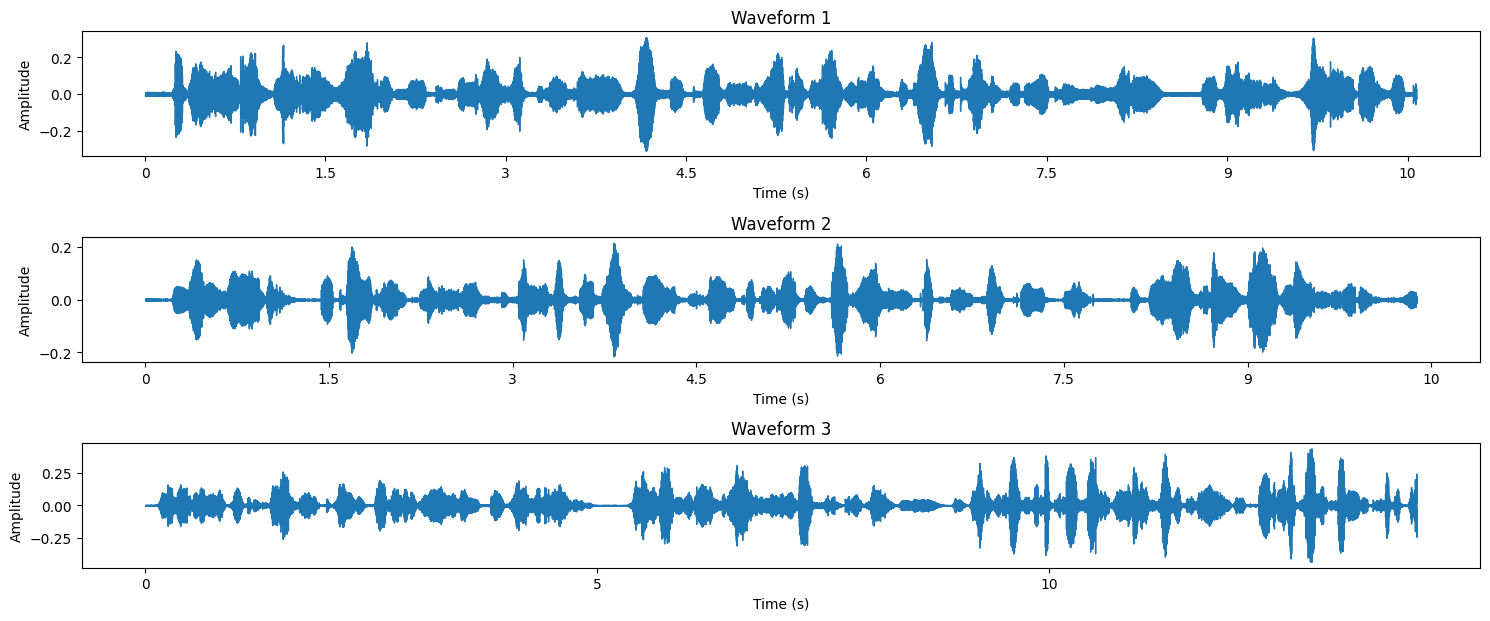

In [10]:
import os
import random
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt

def convert_to_wav(input_file, output_file):
    # Read audio file and convert to WAV
    y, sr = librosa.load(input_file, sr=None)
    sf.write(output_file, y, sr, format='WAV')

# Directory containing the FLAC files
flac_directory = "./mixed_audio/train"

# Get a list of all FLAC files in the directory
flac_files = [os.path.join(flac_directory, f) for f in os.listdir(flac_directory) if f.endswith('.flac')]

# Randomly select 5 FLAC files
random_flac_files = random.sample(flac_files, 3)

# Convert each selected FLAC file to WAV
wav_files = []
for flac_file in random_flac_files:
    wav_file = flac_file.replace('.flac', '.wav')
    convert_to_wav(flac_file, wav_file)
    wav_files.append(wav_file)

# Plot the waveforms
plt.figure(figsize=(15, 10))

for i, wav_file in enumerate(wav_files):
    # Load the WAV audio file
    y, sr = librosa.load(wav_file, sr=None)
    
    # Create the time axis for the waveform
    time = librosa.times_like(y, sr=sr)
    
    # Plot the waveform
    plt.subplot(5, 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Mixed audio sample {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Clean up temporary WAV files
for wav_file in wav_files:
    os.remove(wav_file)


In [8]:
#Generating the mixed audio test dataset
output_dir_test="/teamspace/studios/this_studio/mixed_audio/test"
u.generate_data(output_dir_test,librispeech_dir)
print("Testing data generated")

Testing data generated


In [6]:
from mixed_audio_dataset import MixedAudioDataset

#Using the dataset class
mixed_dir = "/teamspace/studios/this_studio/mixed_audio/train"
clean_dir = "/teamspace/studios/this_studio/Data/train-clean-100"
dataset = MixedAudioDataset(mixed_dir, clean_dir)


In [7]:
#printing the length of the 1st mixed-audio tensor
print(len(dataset[1][1]))

112000


In [12]:
from models import UNet
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [13]:
# Define training parameters
batch_size = 16
learning_rate = 0.000000001
num_epochs = 10
# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the device
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=u.collate_fn)

In [27]:
# Training loop
loss_function = u.si_sdr_loss

for epoch in range(num_epochs):
    running_loss = 0.0
    for mixed_audio, clean_audio1, clean_audio2 in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Zero the parameter gradients
        mixed_audio = mixed_audio.to(device)
        clean_audio1 = clean_audio1.to(device)
        clean_audio2 = clean_audio2.to(device)
        optimizer.zero_grad()
        # print(len(mixed_audio),len(clean_audio1),len(clean_audio2),"\n")
        # Forward pass
        mixed_audio_pred = model(mixed_audio.unsqueeze(1))  # Add channel dimension

        # Compute the SI-SDR loss
        loss = loss_function(mixed_audio_pred, torch.stack((clean_audio1, clean_audio2), dim=1))

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(data_loader)))

# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')

Epoch 1/10: 100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Epoch [1/10], Loss: 62.5474


Epoch 2/10: 100%|██████████| 97/97 [01:16<00:00,  1.26it/s]


Epoch [2/10], Loss: 62.4285


Epoch 3/10: 100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Epoch [3/10], Loss: 62.4124


Epoch 4/10: 100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Epoch [4/10], Loss: 62.6143


Epoch 5/10: 100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Epoch [5/10], Loss: 62.4762


Epoch 6/10: 100%|██████████| 97/97 [01:16<00:00,  1.26it/s]


Epoch [6/10], Loss: 62.5200


Epoch 7/10: 100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Epoch [7/10], Loss: 62.4585


Epoch 8/10: 100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Epoch [8/10], Loss: 62.4439


Epoch 9/10: 100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Epoch [9/10], Loss: 62.5520


Epoch 10/10: 100%|██████████| 97/97 [01:16<00:00,  1.27it/s]

Epoch [10/10], Loss: 62.5835


### Generating seperated audio through the model

In [19]:
import soundfile as sf
# Load the mixed audio sample
mixed_audio_path = "/teamspace/studios/this_studio/mixed_audio/test/1040-133433-0000.flac_89-218-0002.flac"
mixed_audio, sr = sf.read(mixed_audio_path)

# Preprocessing the mixed audio
# Converting to tensor and reshaping
mixed_audio_tensor = torch.FloatTensor(mixed_audio).unsqueeze(0)  # Add batch dimension

# Setting the model to evaluation mode
model.eval()

# Move the mixed audio tensor to the device
mixed_audio_tensor = mixed_audio_tensor.to(device)

# Forward pass to obtain separated audio predictions
with torch.no_grad():  # Disable gradient calculation during evaluation
    mixed_audio_pred = model(mixed_audio_tensor.unsqueeze(1))  # Add channel dimension
# Extract separated audio signals from the predictions
separated_audio1 = mixed_audio_pred[:, 0, :]  # Assuming the model outputs 2-channel audio
separated_audio2 = mixed_audio_pred[:, 1, :]  # Assuming the model outputs 2-channel audio
# Convert tensors to numpy arrays (if needed)
separated_audio1_np = separated_audio1.transpose(1, 0).cpu().numpy()
separated_audio2_np = separated_audio2.transpose(1, 0).cpu().numpy()
# Visualize or listen to the separated audio signals
# For example, you can use matplotlib to plot the waveforms or listen to the audio using soundfile or another audio library.


# Define the directory to save the separated audio files
output_dir = ""

# Save the separated audio signals as sound files
sf.write(os.path.join(output_dir, "./output/separated_audio1.flac"), separated_audio1_np, sr)
sf.write(os.path.join(output_dir, "./output/separated_audio2.flac"), separated_audio2_np, sr)

print("Source seperated files generated at ./output")

Source seperated files generated at ./output


## Implementing a modified version of ConvTasNet [Cosentino 2020]

In [20]:
from models import ConvTasNet

In [8]:
num_sources = 2  # Assuming separating two audio sources
batch_size = 1
learning_rate = 0.0000001
num_epochs = 10
# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the device
model = ConvTasNet(num_sources).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=u.collate_fn)

# Define your dataset and data loader
# Assuming you have already defined your dataset and data loader

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for mixed_audio, clean_audio1, clean_audio2 in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Forward pass
        mixed_audio = mixed_audio.to(device)
        clean_audio1 = clean_audio1.to(device)
        clean_audio2 = clean_audio2.to(device)
        mixed_audio = mixed_audio.unsqueeze(1)  # Add channel dimension
        predicted_audio = model(mixed_audio)
        # Compute the loss
        loss = si_sdr_loss(predicted_audio, torch.stack((clean_audio1, clean_audio2), dim=1))
        total_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}")

Epoch 1/10: 100%|██████████| 1538/1538 [16:16<00:00,  1.57it/s]


Epoch 1, Loss: 49.822822831231996


Epoch 2/10: 100%|██████████| 1538/1538 [16:15<00:00,  1.58it/s]


Epoch 2, Loss: 48.11177825431675


Epoch 3/10: 100%|██████████| 1538/1538 [16:15<00:00,  1.58it/s]


Epoch 3, Loss: 47.49289397300452


Epoch 4/10: 100%|██████████| 1538/1538 [16:15<00:00,  1.58it/s]


Epoch 4, Loss: 46.70945685923642


Epoch 5/10: 100%|██████████| 1538/1538 [16:15<00:00,  1.58it/s]


Epoch 5, Loss: 45.83550308708717


Epoch 6/10: 100%|██████████| 1538/1538 [16:15<00:00,  1.58it/s]


Epoch 6, Loss: 44.72494217137211


Epoch 7/10: 100%|██████████| 1538/1538 [16:16<00:00,  1.57it/s]


Epoch 7, Loss: 43.383275996879114


Epoch 8/10: 100%|██████████| 1538/1538 [16:16<00:00,  1.58it/s]


Epoch 8, Loss: 41.90010887686701


Epoch 9/10: 100%|██████████| 1538/1538 [16:16<00:00,  1.57it/s]


Epoch 9, Loss: 40.44778160248993


Epoch 10/10: 100%|██████████| 1538/1538 [16:16<00:00,  1.58it/s]

Epoch 10, Loss: 39.113123455965315


### Generating seperated audio through ConvTasnet

In [25]:
import torch

# Load the mixed audio sample
mixed_audio_path = "/teamspace/studios/this_studio/mixed_audio/test/1040-133433-0000.flac_89-218-0002.flac"
mixed_audio, sr = sf.read(mixed_audio_path)

# Preprocess the mixed audio (if needed)
# For example, convert to tensor and reshape
mixed_audio_tensor = torch.FloatTensor(mixed_audio).unsqueeze(0)  # Add batch dimension

# Set the model to evaluation mode
model.eval()

# Move the mixed audio tensor to the device
mixed_audio_tensor = mixed_audio_tensor.to(device)

# Forward pass to obtain separated audio predictions
with torch.no_grad():  # Disable gradient calculation during evaluation
    mixed_audio_pred = model(mixed_audio_tensor.unsqueeze(1))  # Add channel dimension
# Extract separated audio signals from the predictions
separated_audio1 = mixed_audio_pred[:, 0, :]  # Assuming the model outputs 2-channel audio
separated_audio2 = mixed_audio_pred[:, 1, :]  # Assuming the model outputs 2-channel audio
# Convert tensors to numpy arrays (if needed)
separated_audio1_np = separated_audio1.transpose(1, 0).cpu().numpy()
separated_audio2_np = separated_audio2.transpose(1, 0).cpu().numpy()

# Visualize or listen to the separated audio signals
# For example, you can use matplotlib to plot the waveforms or listen to the audio using soundfile or another audio library.
import soundfile as sf

# Define the directory to save the separated audio files
output_dir = ""

# Save the separated audio signals as sound files
sf.write(os.path.join(output_dir, "./output/separated_audio3.flac"), separated_audio1_np, sr)
sf.write(os.path.join(output_dir, "./output/separated_audio4.flac"), separated_audio2_np, sr)

print("Source seperated files generated at ./output")

Source seperated files generated at ./output


### Displaying source seperated and mixed waveforms

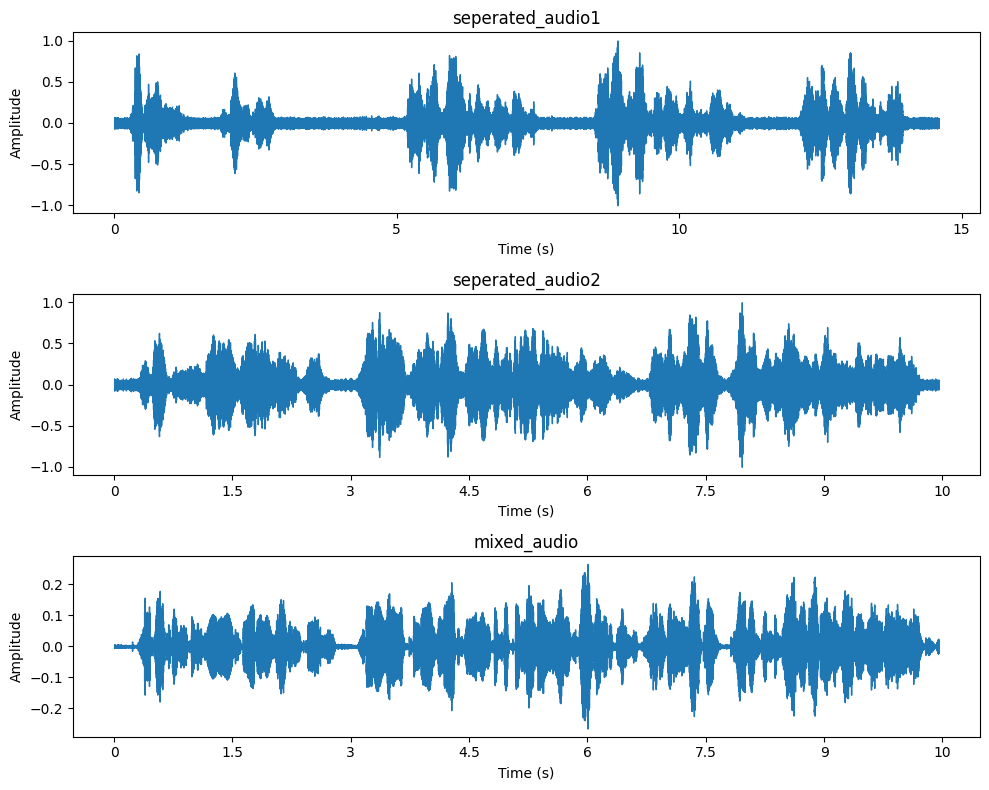

In [3]:
import soundfile as sf
import librosa.display
import matplotlib.pyplot as plt
import os

def convert_to_wav(input_file, output_file):
    # Read audio file and convert to WAV
    y, sr = librosa.load(input_file, sr=None)
    sf.write(output_file, y, sr, format='WAV')

# Define the input FLAC files and temporary WAV files
flac_files = ["output/seperated_audio1.flac", "output/seperated_audio2.flac", "mixed_audio/test/1040-133433-0000.flac_89-218-0002.flac"]
wav_files = ["temp_audio_1.wav", "temp_audio_2.wav", "temp_audio_3.wav"]

# Convert each FLAC file to WAV
for flac_file, wav_file in zip(flac_files, wav_files):
    convert_to_wav(flac_file, wav_file)

# Load the WAV audio files
y_flac, sr_flac = librosa.load(wav_files[0], sr=None)
y_second, sr_second = librosa.load(wav_files[1], sr=None)
y_third, sr_third = librosa.load(wav_files[2], sr=None)

# Create the time axes for the waveforms
time_flac = librosa.times_like(y_flac, sr=sr_flac)
time_second = librosa.times_like(y_second, sr=sr_second)
time_third = librosa.times_like(y_third, sr=sr_third)

# Plot the waveforms
plt.figure(figsize=(10, 8))

# Plot the FLAC audio waveform
plt.subplot(3, 1, 1)
librosa.display.waveshow(y_flac, sr=sr_flac)
plt.title('seperated_audio1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the second audio waveform
plt.subplot(3, 1, 2)
librosa.display.waveshow(y_second, sr=sr_second)
plt.title('seperated_audio2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the third audio waveform
plt.subplot(3, 1, 3)
librosa.display.waveshow(y_third, sr=sr_third)
plt.title('mixed_audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Clean up temporary WAV files
for wav_file in wav_files:
    os.remove(wav_file)


In [14]:
import soundfile as sf

def convert_flac_to_wav(flac_file, wav_file):
    """
    Convert a FLAC audio file to WAV format.

    Parameters:
        flac_file (str): Path to the input FLAC audio file.
        wav_file (str): Path to the output WAV audio file.
    """
    # Read the FLAC audio file
    y, sr = sf.read(flac_file)

    # Write the audio data to a WAV file
    sf.write(wav_file, y, sr, format='WAV')

# Example usage:
flac_file = "Data/train-clean-100/89/218/89-218-0002.flac"
wav_file = "seperated_2.wav"
convert_flac_to_wav(flac_file, wav_file)


In [15]:
from IPython.display import Audio

# Path to the WAV audio file
wav_file_mixed = "mixed_audio.wav"

# Display the audio player
Audio(wav_file_mixed)

# Path to the WAV audio file
wav_file_mixed = "seperated_1.wav"

# Display the audio player
Audio(wav_file_mixed)
# Path to the WAV audio file
wav_file_mixed = "seperated_2.wav"

# Display the audio player
Audio(wav_file_mixed)

Further steps:
1. Calculate meaningful performance measures such as SI-SDRI.
2. Fine tune the ConvTasNet architecture.
3. Adding a variety of data augmentations to prevent overfitting.